# Data z reálné jízdy (RSX-UM7)
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tconsumption
from umparse import um_csv_parser
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib
import os

In [2]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-23_07-14-50.csv")
df

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


,datetime,packet_type,gps_latitude,gps_longitude,gps_altitude,gps_course,gps_speed,gps_time,gyro_proc_x,gyro_proc_y,...,mag_proc_z,mag_proc_time,velocity_north,velocity_east,velocity_up,velocity_time,delta_T,velocity,distance_m,cumulative_distance_m
0,2023-09-23 06:14:50.528545024,UM7AllProcPacket,NaN,NaN,NaN,NaN,NaN,NaN,0.106324,0.160977,...,1.187676,26092.794922,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,2023-09-23 06:14:50.844794112,UM7AllProcPacket,NaN,NaN,NaN,NaN,NaN,NaN,0.104511,0.160759,...,1.200215,26093.119141,NaN,NaN,NaN,NaN,0 days 00:00:00.316249088,NaN,NaN,NaN
2,2023-09-23 06:14:51.206500096,UM7AllProcPacket,NaN,NaN,NaN,NaN,NaN,NaN,0.226461,0.220143,...,1.193567,26093.443359,NaN,NaN,NaN,NaN,0 days 00:00:00.361705984,NaN,NaN,NaN
3,2023-09-23 06:14:51.544763136,UM7GPSPacket,49.787090,18.135666,255.300003,0.0,0.168611,26093.0,0.226461,0.220143,...,1.193567,26093.443359,NaN,NaN,NaN,NaN,0 days 00:00:00.338263040,NaN,NaN,NaN
4,2023-09-23 06:14:51.879555840,UM7GPSPacket,49.787090,18.135668,255.300003,0.0,0.076389,26094.0,0.226461,0.220143,...,1.193567,26093.443359,NaN,NaN,NaN,NaN,0 days 00:00:00.334792704,NaN,0.13693,0.136930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80265,2023-09-23 15:33:56.494110208,UM7GPSPacket,49.787205,18.135544,253.000000,0.0,0.049722,59638.0,-0.109189,0.269442,...,0.838564,59635.664062,0.0,0.0,-0.0,0.0,0 days 00:00:00.670259200,0.0,0.13693,7041.850786
80266,2023-09-23 15:33:56.831290112,UM7GPSPacket,49.787205,18.135544,253.000000,0.0,0.049722,59638.0,-0.109189,0.269442,...,0.838564,59635.664062,0.0,0.0,-0.0,0.0,0 days 00:00:00.337179904,0.0,0.00000,7041.850786
80267,2023-09-23 15:33:57.503372032,UM7GPSPacket,49.787205,18.135546,253.100006,0.0,0.065833,59639.0,-0.109189,0.269442,...,0.838564,59635.664062,0.0,0.0,-0.0,0.0,0 days 00:00:00.672081920,0.0,0.13693,7041.987715
80268,2023-09-23 15:33:57.840486144,UM7GPSPacket,49.787205,18.135546,253.100006,0.0,0.065833,59639.0,-0.109189,0.269442,...,0.838564,59635.664062,0.0,0.0,-0.0,0.0,0 days 00:00:00.337114112,0.0,0.00000,7041.987715


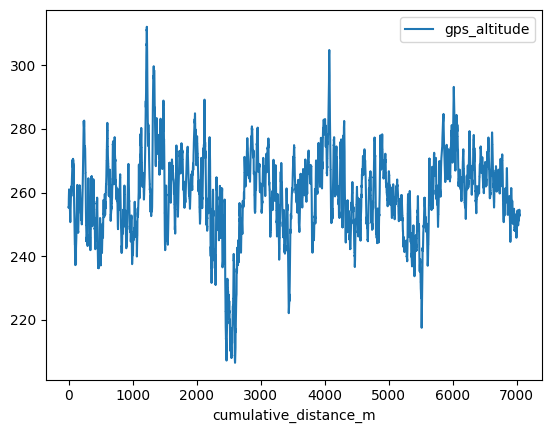

<Figure size 2000x480 with 0 Axes>

In [5]:
df.plot(x="cumulative_distance_m", y=["gps_altitude"])

In [6]:
velocity_segment_cache = {}

In [11]:
def compare_data(csv_path: str, geojson_path: str):
    # Data identification
    data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.params["mass_locomotive"] = 34500
    # c.variable_params["Recuperation coefficient"] = 0.38
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    }
    c.load_from_file(geojson_path)

    # Measured data
    df = tram_csv_parser(csv_path)

    # Modifying some parameters
    print("Graphs for data:", data_name)
    print("Max power from measured data:", df["cela_vykon_vyrovnany_bez_spotrebicu"].max())
    # c.params["power_limit"] = None
    c.params["power_limit"] = 600*1000
    # c.params["acceleration_limit"] = 1*G_TO_MS2

    # Inferring stops
    stations_stopped = []
    last_row_zero = 0
    for i,row in enumerate(df["tm_rychlost_3_napravy"]):
        if row < 1:
            if last_row_zero < i-1:
                stations_stopped.append(i)
            last_row_zero = i
    c.stations = [c.stations[0]] + stations_stopped + [c.stations[-1]]

    # Getting velocity segments
    if data_name not in velocity_segment_cache:
        algo = rpt.Pelt(model="rbf").fit(df["tm_rychlost_3_napravy"].values)
        result = algo.predict(pen=100)
        velocity_segment_cache[data_name] = result.copy()
    else:
        result = velocity_segment_cache[data_name].copy()

    to_remove = []
    for i,r in enumerate(result):
        if i == 0:
            continue
        slice = df["tm_rychlost_3_napravy"][result[i-1]:r]
        # if len(slice) < 100 or len(slice)/2 < len([x for x in slice if x <= 0]):
        if len(slice)/4 < len([x for x in slice if x <= 0]):
            to_remove.append(i-1)
    to_remove.reverse()
    for i in to_remove:
        del result[i]

    # fig, ax = plt.subplots()
    # fig.set_figwidth(20)
    # ax.plot(list(df["tm_rychlost_3_napravy"]), color="tab:red")
    # plt.title("Velocity change points")
    # for r in result:
    #     ax.axvline(x=r, color="k", linestyle="--")
    # plt.show()

    max_velocities = []
    for i,r in enumerate(result):
        if i == 0:
            segment = df["tm_rychlost_3_napravy"][:r]
        else:
            segment = df["tm_rychlost_3_napravy"][result[i-1]:r]
        max_velocities += [max(segment)] * len(segment)

    c.max_velocities_in_mps = max_velocities

    # Running the simulation
    c.run()

    # NOTE: Debugging, DELETE LATER
    # df = df.iloc[c.stations[5]:]

    # Plotting
    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    energy_real = df["cela_energie_vyrovnana_bez_spotrebicu"]
    print(f"Simulation final energy: {energy_calculated[-1]}")
    print(f"Real final energy: {energy_real.iloc[-1]}")

    plt.figure().set_figwidth(20)
    start_slice = 0
    plt.plot(c.series["dist_values"][start_slice:], energy_calculated[start_slice:])
    plt.plot(c.series["dist_values"][start_slice:], energy_real[start_slice:])
    plt.title("Energy")
    plt.legend(["Simulation", "Real"], loc ="upper right")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["braking_at_the_end"])
    plt.title("Braking at the end")
    plt.show()

    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.series["exerted_force_values"])
    # plt.title("Exerted force")
    # plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], [x[2] for x in c.points])
    plt.title("Elevation")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["velocity_values"])
    plt.plot(c.series["dist_values"], df["tm_rychlost_3_napravy"])
    plt.title("Velocity")
    plt.legend(["Simulation", "Real"], loc ="upper right")
    plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], c.series["velocity_values"])
    # plt.title("Calculated velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], list(df["tm_rychlost_3_napravy"]))
    # plt.title("Real velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.max_velocities_in_mps)
    # plt.title("Velocity limit")
    # plt.show()

    # return c.series

Graphs for data: 01-Vozovna-Vresinska_2022-04-20
Max power from measured data: 669.9246400000001
Simulation final energy: 2.8470983683367472
Real final energy: 2.6208498721944276


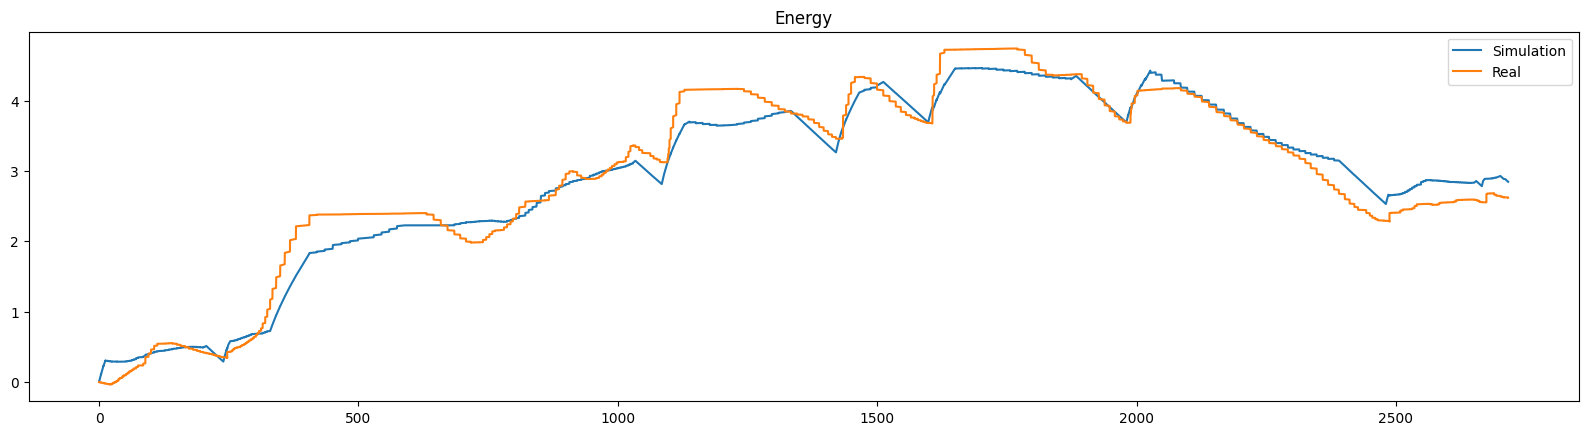

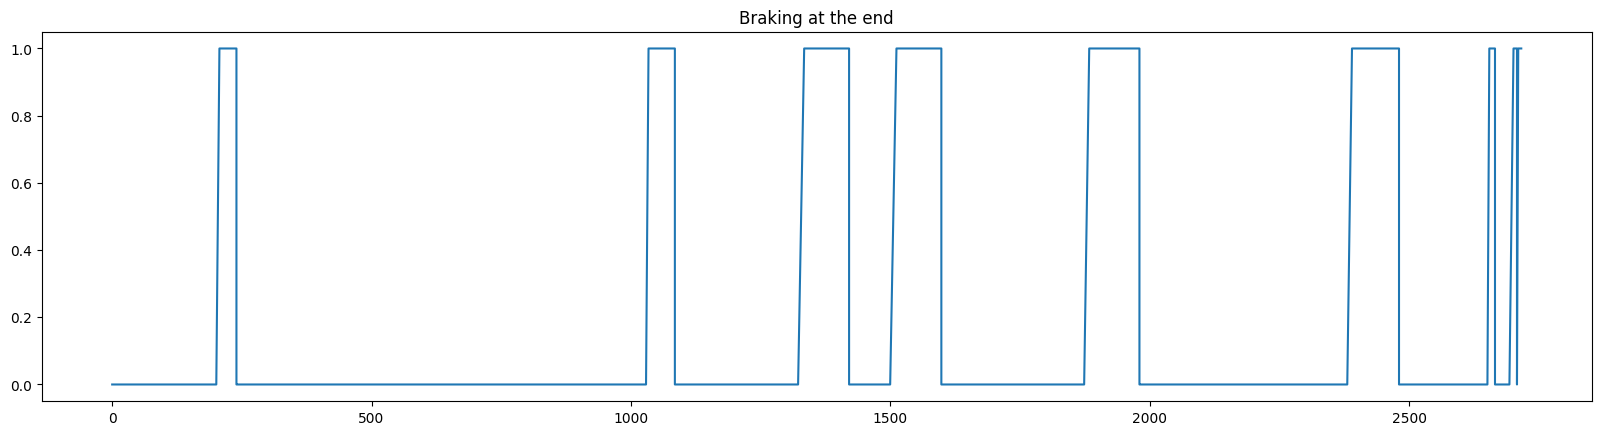

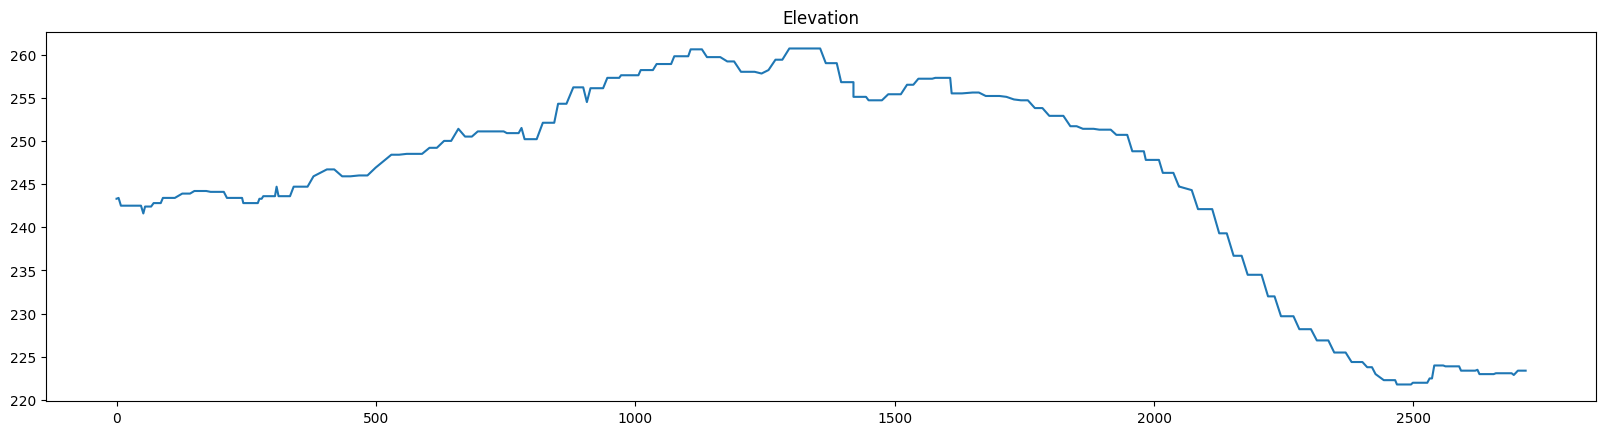

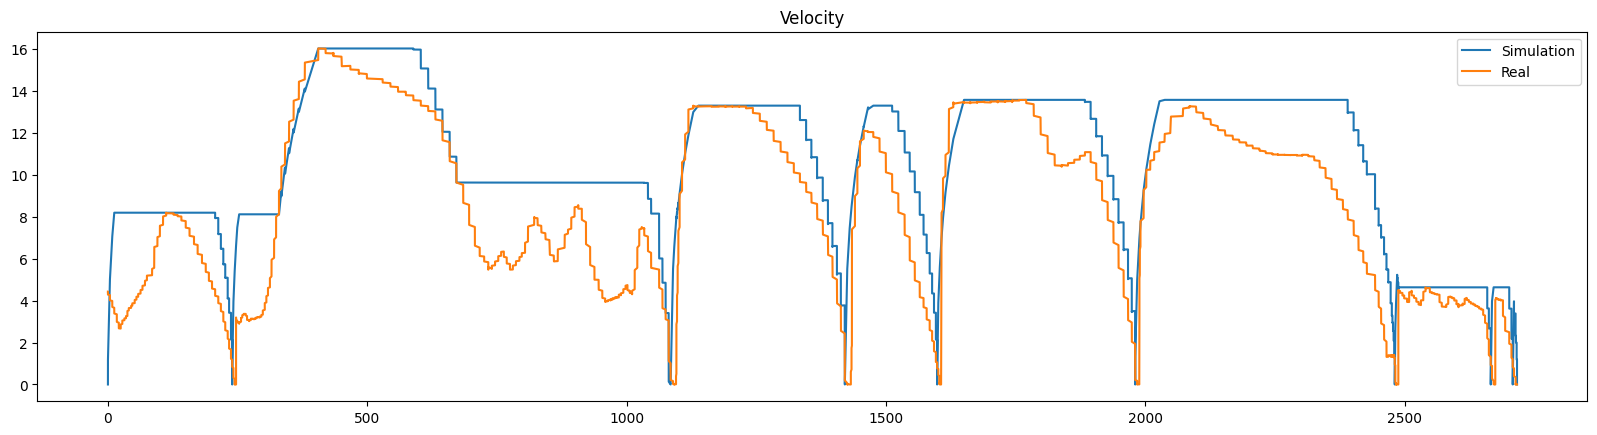

Graphs for data: 02-Vresinska-Zatisi_2022-04-20
Max power from measured data: 598.9970400000001
Simulation final energy: 18.025754329620824
Real final energy: 19.862349672311073


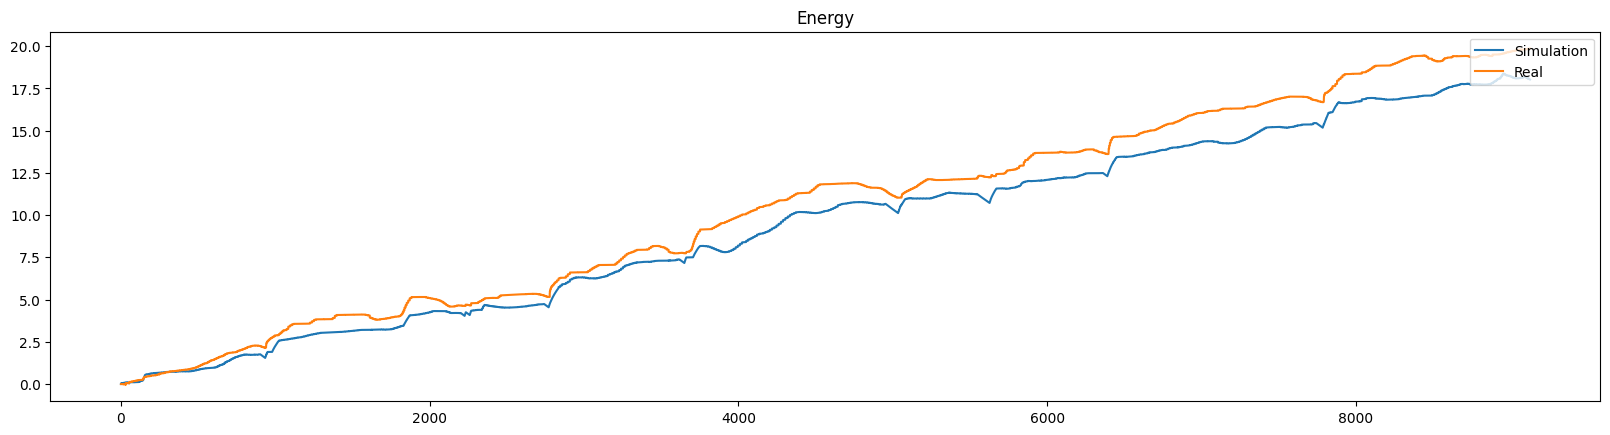

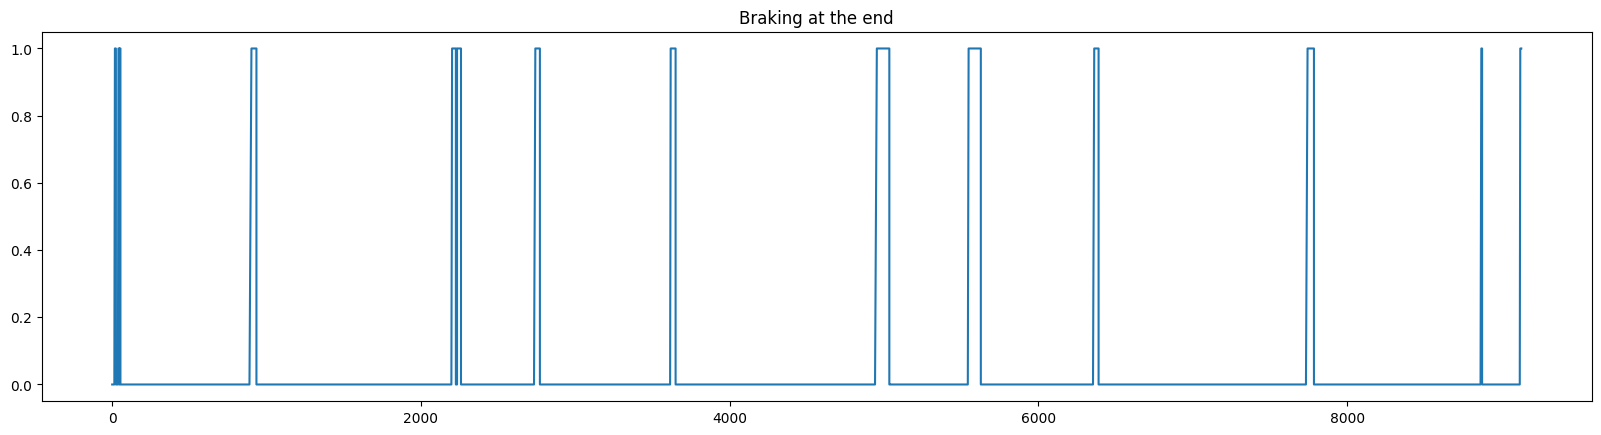

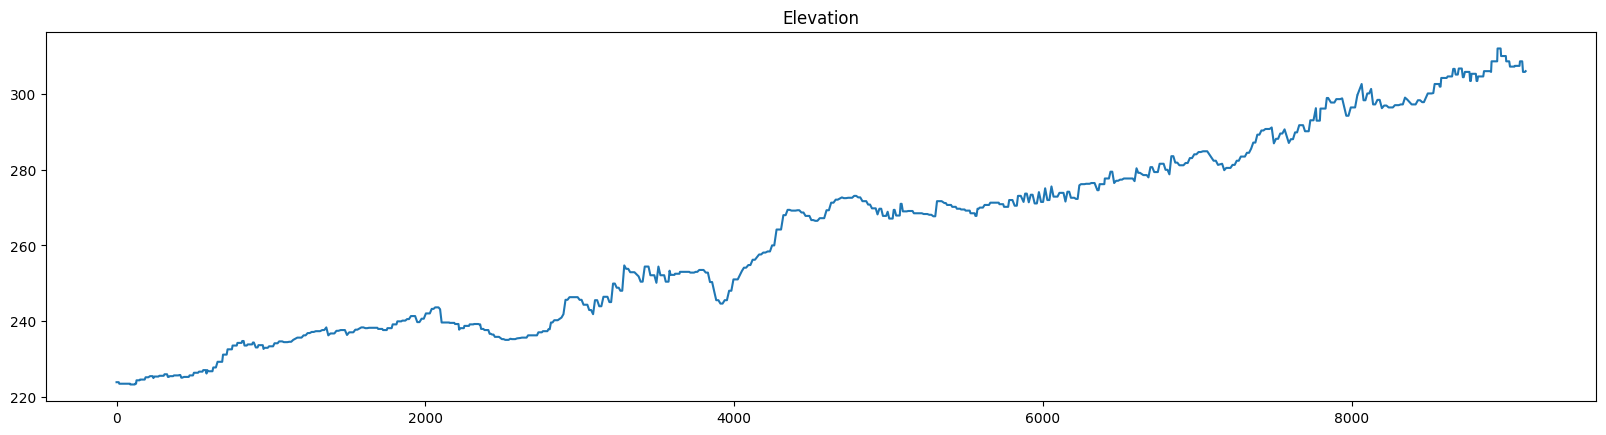

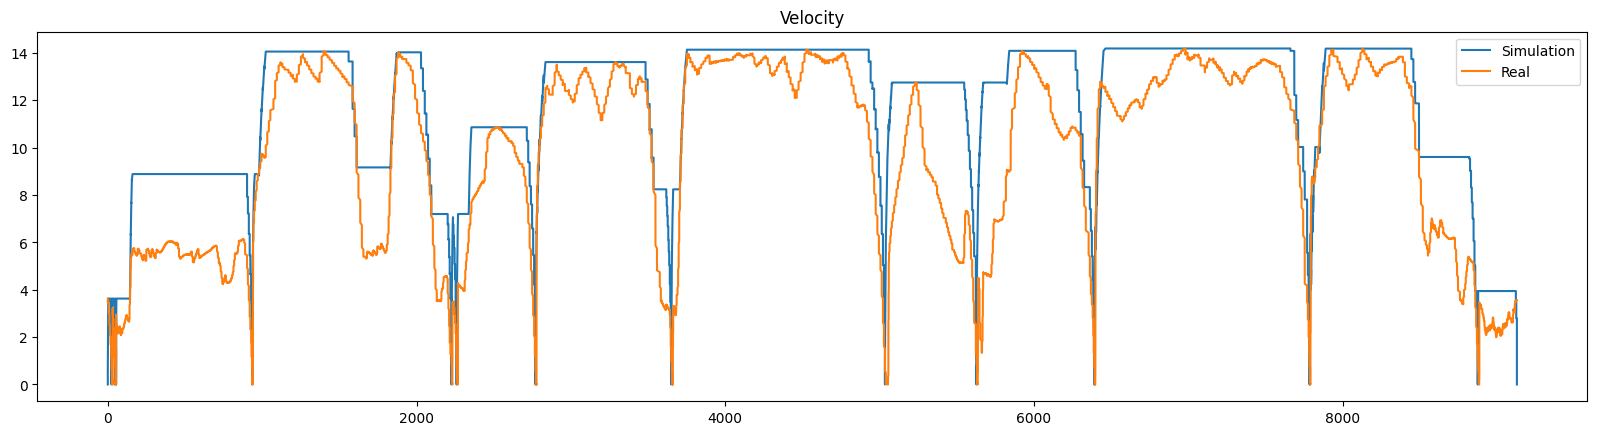

Graphs for data: 03-Zatisi-Vresinska_2022-04-20
Max power from measured data: 654.90727
Simulation final energy: 4.661949392589272
Real final energy: 6.5903815945083215


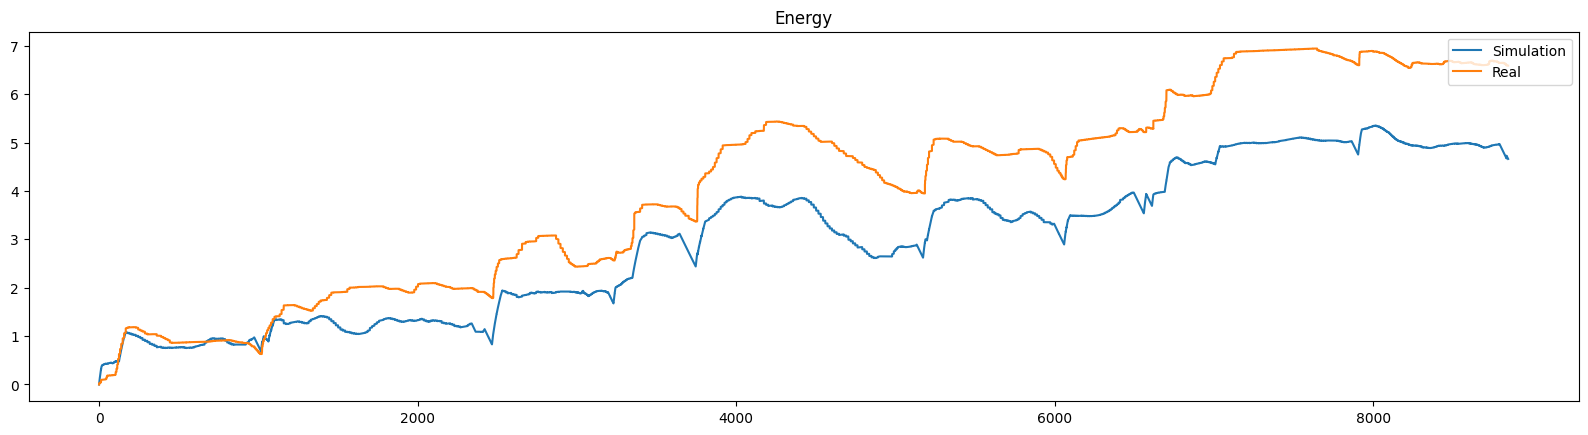

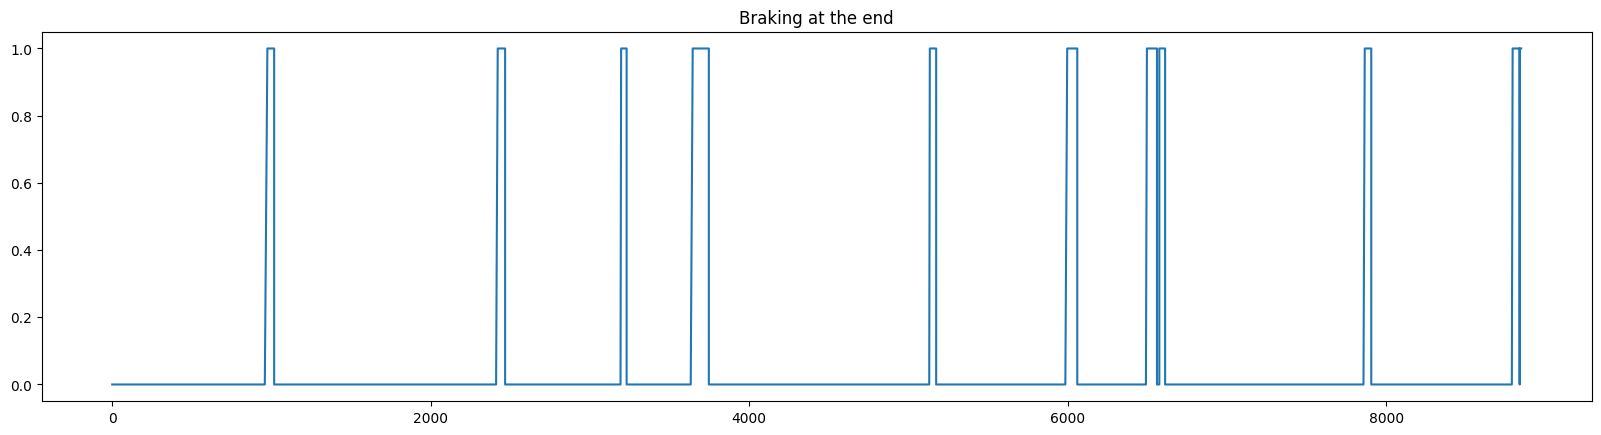

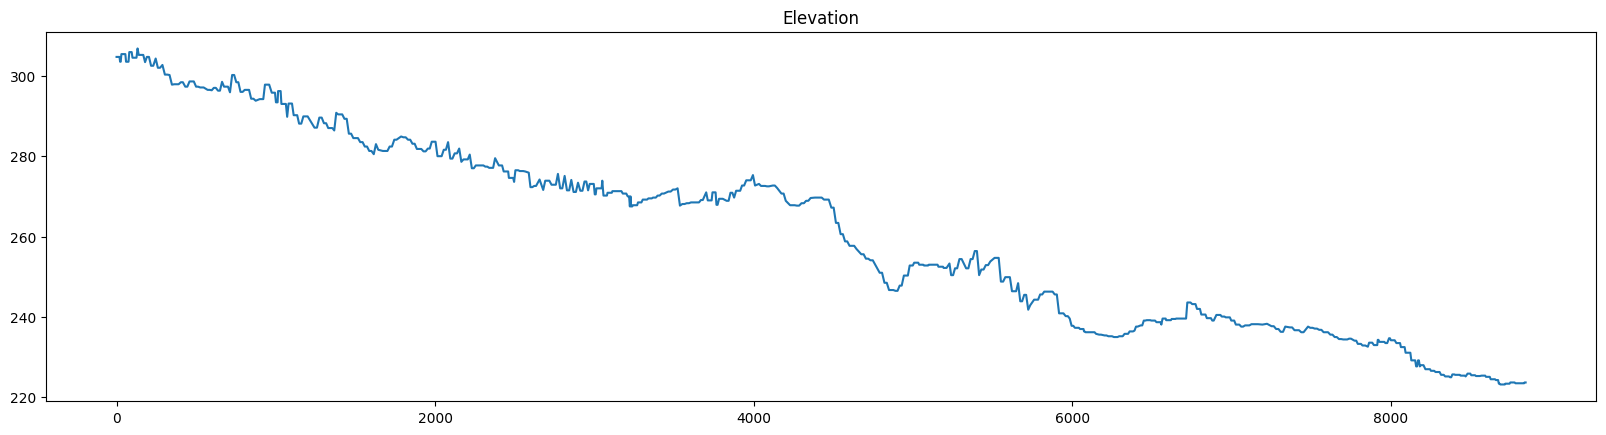

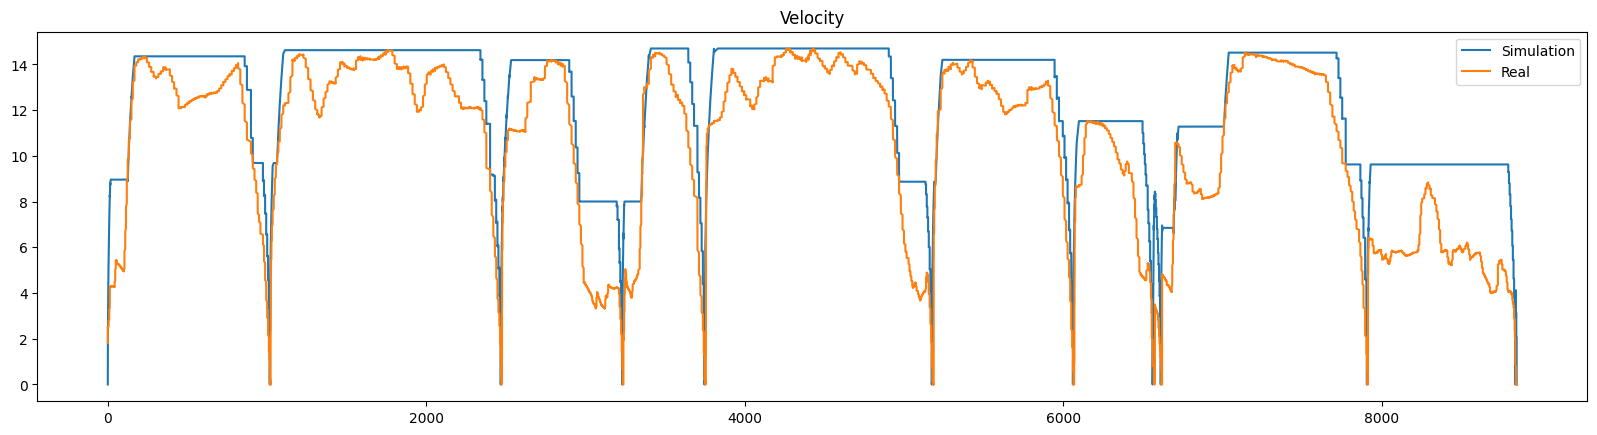

Graphs for data: 1710_02
Max power from measured data: 649.84375
Simulation final energy: 17.5743093567866
Real final energy: 21.020934534003032


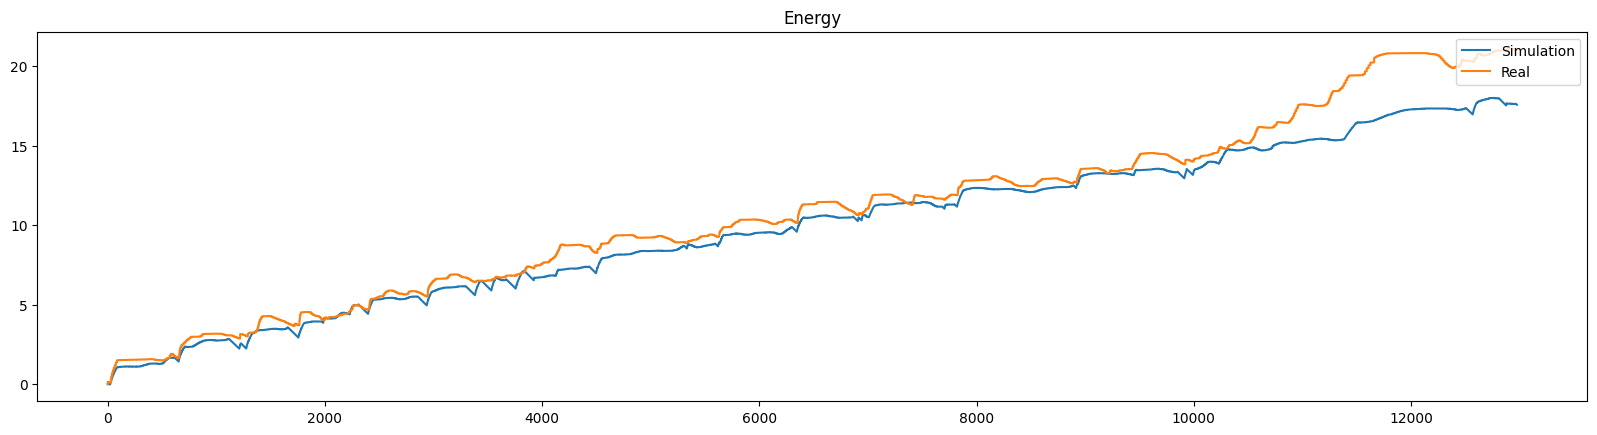

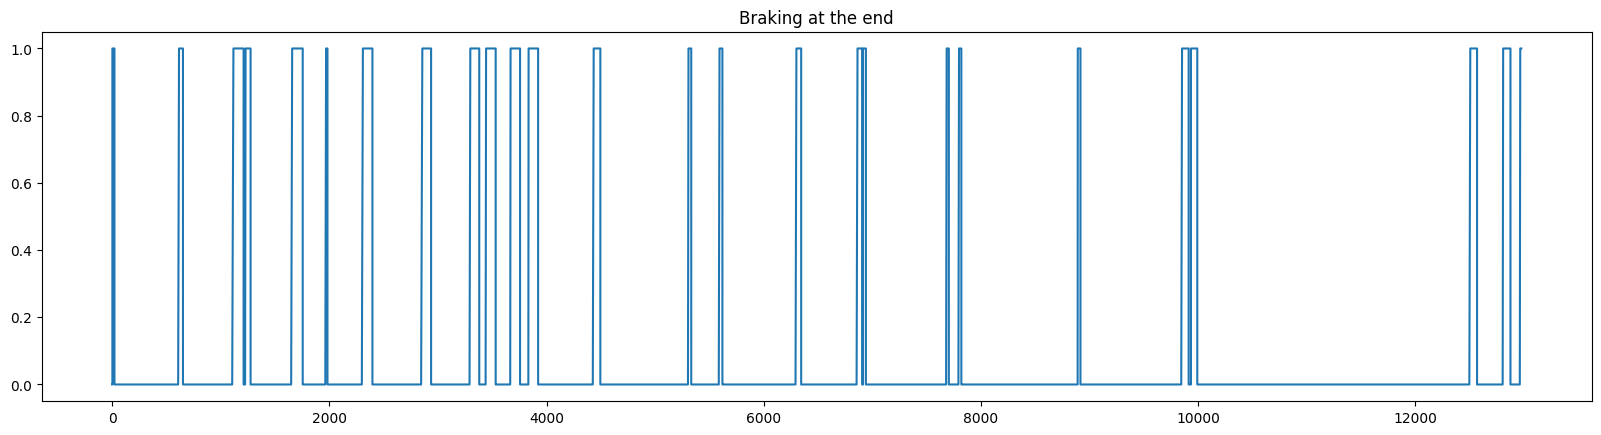

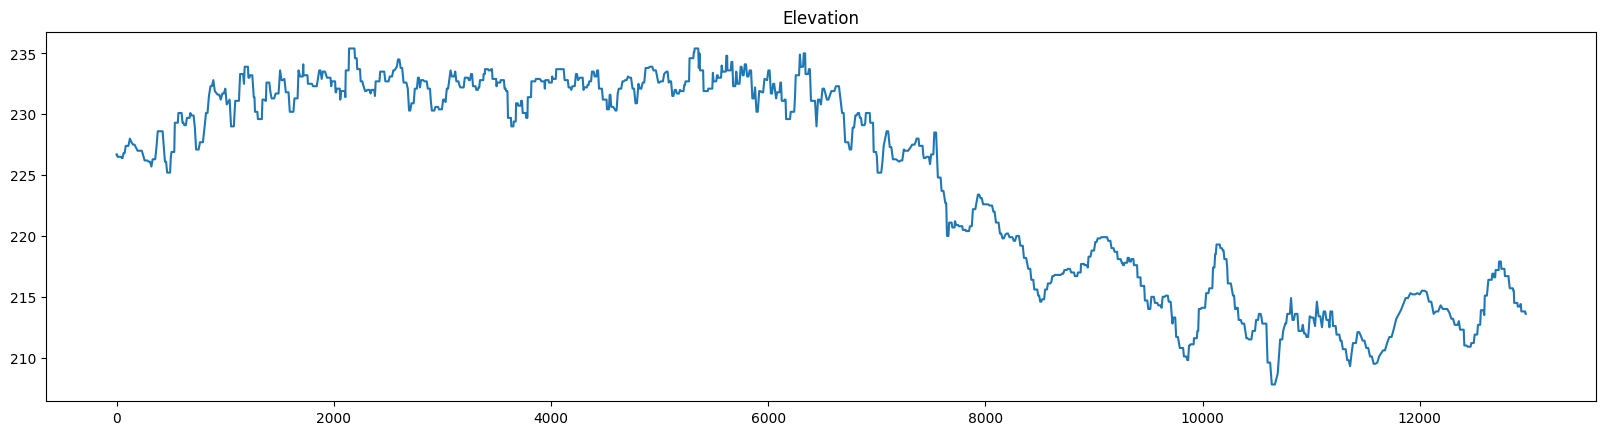

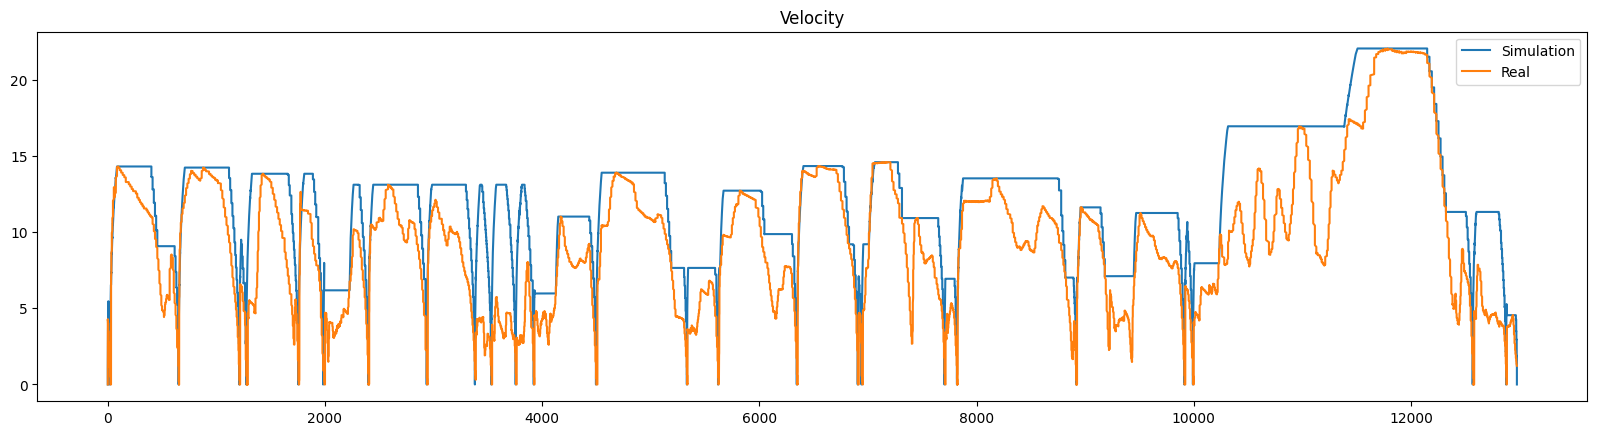

In [12]:
importlib.reload(tconsumption)

# del velocity_segment_cache["01-Vozovna-Vresinska_2022-04-20"]
compare_data(
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.csv",
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.geojson"
)

compare_data(
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.csv",
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.geojson"
)

compare_data(
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.csv",
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.geojson"
)

compare_data(
    "../testing-data/DPO/Jizdy_Centrum_07-08-12_07.2022/1710_02.csv",
    "../testing-data/DPO/Jizdy_Centrum_07-08-12_07.2022/1710_02.geojson"
)